In [2]:
#import packages that will be used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
np.random.seed(42)
import sqlite3 as sl 
%matplotlib inline

In [3]:
con = sl.connect('tweets')
corpus2 = pd.read_sql("""
                    SELECT tweet_text, is_there_an_emotion_directed_at_a_brand_or_product
                    FROM tweets
                    WHERE tweet_text != 'None'
                    AND is_there_an_emotion_directed_at_a_brand_or_product IN ('Positive emotion','Negative emotion')
                    AND tweet_text NOT like 'RT%'
                    """,con)
corpus2.head()

,tweet_text,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Positive emotion


In [4]:
import nltk
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
sw = stopwords.words('english')

In [5]:
from nltk.corpus import wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer 
  
def get_wordnet_pos(treebank_tag):
    '''
    Translate nltk POS to wordnet tags
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
def doc_preparer(doc, stop_words=sw):
    '''  
    :param doc: a document from the corpus 
    :return: a document string with words which have been 
            lemmatized, 
            parsed for stopwords, 
            made lowercase,
            and stripped of punctuation and numbers.
    '''
    
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")
    doc = regex_token.tokenize(doc)
    doc = [word.lower() for word in doc]
    doc = [word for word in doc if word not in stop_words]
    doc = pos_tag(doc)
    doc = [(word[0], get_wordnet_pos(word[1])) for word in doc]
    lemmatizer = WordNetLemmatizer() 
    doc = [lemmatizer.lemmatize(word[0], word[1]) for word in doc]
    return ' '.join(doc)

In [6]:
sw = stopwords.words('english')
sw.extend(["sxsw","mention","link","ipad","rt","apple","google","iphone",
                  "quot","store","app","new","get","austin","pop","amp","android","launch","go","open"] )

In [7]:
X = corpus2.tweet_text.astype('str')
y = corpus2.is_there_an_emotion_directed_at_a_brand_or_product

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42, test_size=.25)

token_docs = [doc_preparer(doc, sw) for doc in X_train]
token_docs[0]

'know late game really dig flipboard'

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

In [9]:
# Validation train-test split to build our best model
X_t, X_val, y_t, y_val = train_test_split(token_docs, y_train, test_size=.25, random_state=42)

cv = CountVectorizer()

X_t_vec = cv.fit_transform(X_t)
X_t_vec  = pd.DataFrame.sparse.from_spmatrix(X_t_vec)
X_t_vec.columns = sorted(cv.vocabulary_)
X_t_vec.set_index(y_t.index, inplace=True)
X_t_vec

,aapl,abacus,abandon,able,absolute,absolutely,abuzz,acc,access,accessory,...,ze,zelda,zeldman,zero,zgd,zimride,zing,zip,zombie,zomg
2289,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1904,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1843,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
848,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
697,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2156,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
968,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1347,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2163,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()
mnb.fit(X_t_vec, y_t)

MultinomialNB()

In [11]:
prior_0 = y_t.value_counts()['Negative emotion']/len(y_t)
prior_1 = y_t.value_counts()['Positive emotion']/len(y_t)

print(prior_0, prior_1)
print(np.log(prior_1))

0.16883116883116883 0.8311688311688312
-0.18492233849401193


In [12]:
mnb.class_log_prior_

array([-1.77885606, -0.18492234])

In [13]:
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix

y_hat = mnb.predict(X_t_vec)
print(accuracy_score(y_t, y_hat))
print(confusion_matrix(y_t,y_hat))

0.9567099567099567
[[ 212   61]
 [   9 1335]]


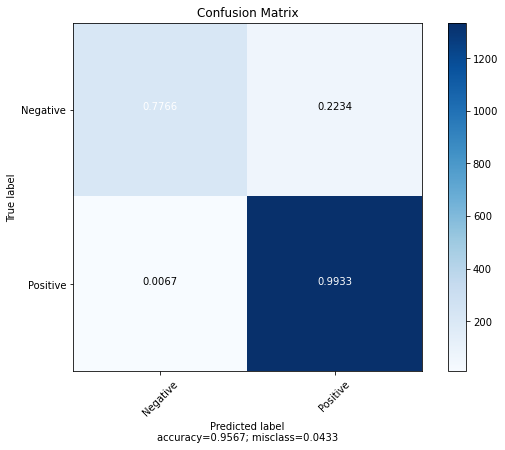

In [14]:
from sklearn.metrics import plot_confusion_matrix

import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
plot_confusion_matrix(cm = np.array(confusion_matrix(y_t,y_hat)), 
                      normalize    = True,
                      target_names = ['Negative', 'Positive'],
                      title        = "Confusion Matrix")
